In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

library(dplyr)
library(ggplot2)
library(readr)
library(stringr)
library(scales)
library(data.table)
library(grid)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following object is masked from ‘package:readr’:

    col_factor


R[write to console]: data.table 1.16.2 using 12 threads (see ?getDTthreads).  
R[write to console]: Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last




In [3]:
%%R
human     <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/Human/Human_nuno_plot_data.tsv")
rhesus    <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/rheMac/rhesus_plot_data_new.tsv")
chimp     <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/Chimp/Chimp_plot_data.tsv")
orangutan <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/Orangutan/orangutan_plot_data.tsv")


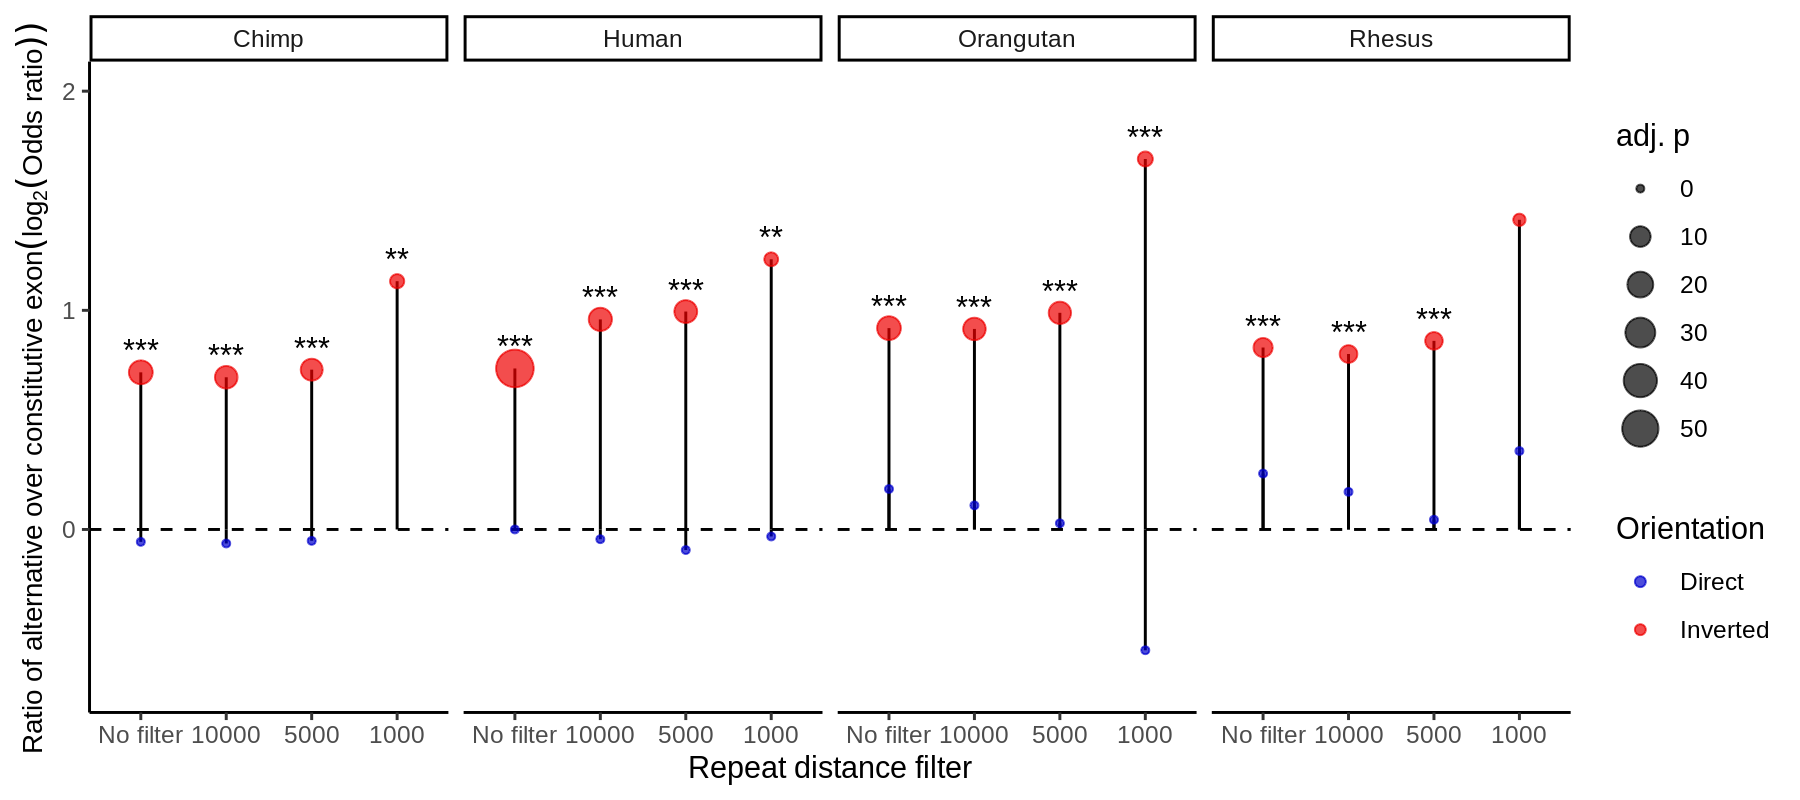

In [7]:
%%R -w 9 -h 4 --units in -r 200

# 2. Add a 'species' column to each dataset
human[, species := "Human"]
rhesus[, species := "Rhesus"]
chimp[, species := "Chimp"]
orangutan[, species := "Orangutan"]

# 3. Combine all data into one data.table
all_data <- rbind(human, rhesus, chimp, orangutan, fill = TRUE)

# 4. Compute Bonferroni-adjusted p-values (assuming each dataset has a column 'P_Value')
all_data[, adj_p_val := p.adjust(P_Value, method = "bonferroni")]

# 5. Create significance labels based on adj_p_val
all_data[, significance := cut(adj_p_val,
                                 breaks = c(0, 0.001, 0.01, 0.05, 1),
                                 labels = c("***", "**", "*", "ns"))]

# 6. Ensure Dist_threshold is a factor with the desired order
all_data[, Dist_threshold := factor(Dist_threshold,
                                     levels = c("No filter", "10000", "5000", "1000"))]

# 7. Create the plot with facet_wrap to display all species side by side
multi_species_plot <- ggplot(all_data, aes(x = Dist_threshold, y = log2(Odds_Ratio))) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_segment(aes(x = Dist_threshold, xend = Dist_threshold, 
                   y = 0, yend = log2(Odds_Ratio)),
               color = "black", size = 0.5) +
  geom_point(aes(colour = Type, size = -log10(adj_p_val)), alpha = 0.7) +
  geom_text(data = subset(all_data, significance != "ns"),
            aes(label = significance),
            vjust = -0.5) +
  facet_wrap(~ species, nrow = 1) +
  xlab("Repeat distance filter") +
  ylab(expression("Ratio of alternative over constitutive exon" * (log[2]("Odds ratio")))) +
  ylim(c(-0.7, 2)) +
  scale_colour_manual(name = "Orientation",
                      values = c("Direct" = "blue3", "Inverted" = "red2")) +
  scale_size_continuous(name = "adj. p") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.title.y = element_text(size = 10))

print(multi_species_plot)


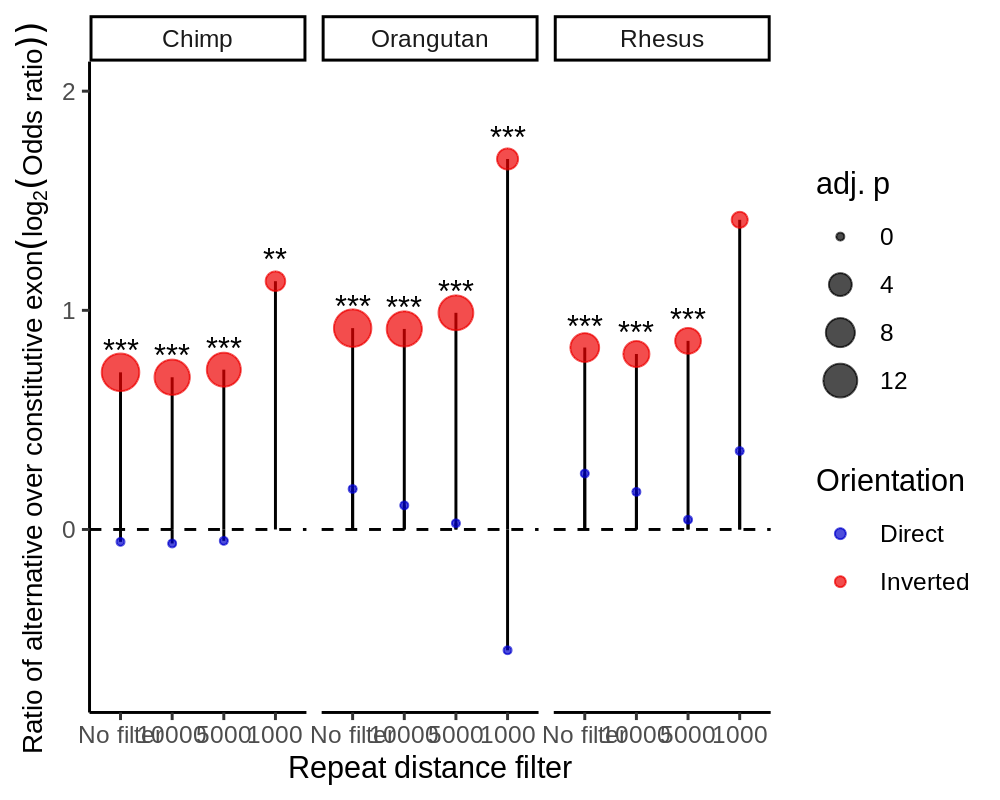

In [8]:
%%R -w 5 -h 4 --units in -r 200

# Figure 2A for just Rhesus, Chimp, and Orangutan

# 1. Define the set of species you want
target_species <- c("Rhesus", "Chimp", "Orangutan")

# 2. Filter your data.table (or data.frame) accordingly
primate_data <- all_data[species %in% target_species]

# 3. Build the plot, faceting over those three species
primate_plot <- ggplot(primate_data, aes(x = Dist_threshold,
                                         y = log2(Odds_Ratio))) +
  geom_hline(yintercept = 0,
             linetype    = "dashed",
             color       = "black",
             size        = 0.5) +
  geom_segment(aes(x     = Dist_threshold,
                   xend  = Dist_threshold,
                   y     = 0,
                   yend  = log2(Odds_Ratio)),
               color = "black",
               size  = 0.5) +
  geom_point(aes(colour = Type,
                 size   = -log10(adj_p_val)),
             alpha = 0.7) +
  # only label the non‐ns points
  geom_text(data = subset(primate_data, significance != "ns"),
            aes(label = significance),
            vjust = -0.5) +
  facet_wrap(~ species, nrow = 1) + 
  xlab("Repeat distance filter") +
  ylab(expression(
    "Ratio of alternative over constitutive exon" *
    (log[2]("Odds ratio"))
  )) +
  ylim(c(-0.7, 2)) +
  scale_colour_manual(name   = "Orientation",
                      values = c("Direct" = "blue3",
                                 "Inverted" = "red2")) +
  scale_size_continuous(name = "adj. p") +
  theme_classic() +
  theme(
    plot.title    = element_text(hjust = 0.5),
    axis.title.y  = element_text(size = 10),
    legend.position = "right"
  )

print(primate_plot)


In [ ]:
%%R

random_Alu_data <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/human_analysis/randomize_Alu_negative_control/Negative_control_data.tsv")

random_Alu_data[ , adj_p_val:=p.adjust(P_Value, method = "bonferroni")]


       Type Dist_threshold Odds_Ratio    P_Value adj_p_val
     <char>         <char>      <num>      <num>     <num>
1:   Direct      No filter   1.119976 0.08056414 0.1611283
2: Inverted      No filter   1.115966 0.11669433 0.2333887


In [ ]:
%%R

random_Alu_data$significance <- cut(random_Alu_data$adj_p_val,
                                         breaks = c(0, 0.001, 0.01, 0.05, 1),
                                         labels = c("***", "**", "*", "ns"))



[1] "No filter" "No filter"


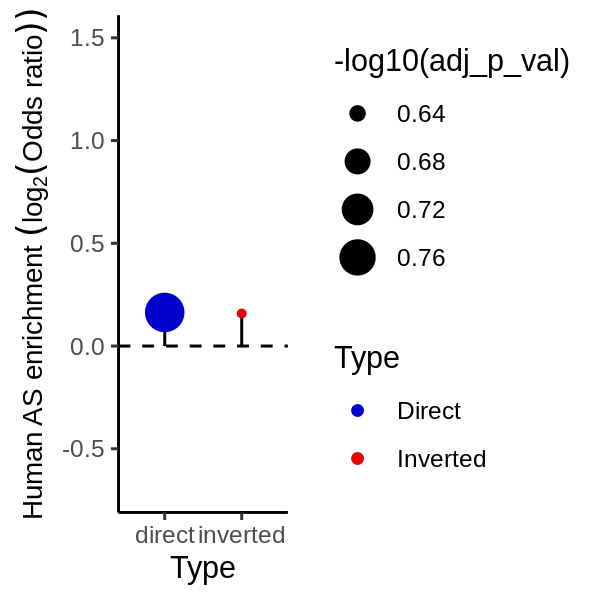

In [ ]:
%%R
#Fig 2B

random_alu_plot <- ggplot(random_Alu_data) +
    geom_hline(yintercept=0, linetype="dashed", color="black") +  
    geom_segment(aes(x=Type, xend=Type, y=0, yend=log2(Odds_Ratio)), color="black") +  
    geom_point(aes(x=Type, y=log2(Odds_Ratio), group=Type, colour=Type, size=-log10(adj_p_val))) +  
    geom_text(data = subset(random_Alu_data, significance != 'ns'),
              aes(x=Type, y=log2(Odds_Ratio), label=significance),
              vjust=-0.5) +  
    xlab('Type') +  
    ylab(expression("Human AS enrichment " * (log[2]("Odds ratio")))) +
    ylim(c(-0.7, 1.5)) +
    scale_x_discrete(labels = c("Direct" = "direct", "Inverted" = "inverted")) +  
    scale_colour_manual(values = c("blue3", "red2")) +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5), axis.title.y = element_text(size = 10))

random_alu_plot